In [ ]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
RS = 7345

# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = pathlib.Path("/content/drive/My Drive/sibur/")

In [ ]:
train = pd.read_csv(DATA_DIR.joinpath("train.csv"), index_col="pair_id")
test = pd.read_csv(DATA_DIR.joinpath("test.csv"), index_col="pair_id")

In [ ]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [ ]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Статистика таргета

In [ ]:
train.is_duplicate.value_counts()

In [ ]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
212631,Sika Kimia Sdn. Bhd.,Sika Lanka (Pvt) Ltd.,1
263042,Bridgestone De Costa Rica S.A.,Bridgestone International Group,1
495980,Bridgestone Firestone Venezolana C,"Bridgestone (Huizhou) Tire Co., Ltd.",1
128297,Basf India Ltd.,Basf Quimica Colombiana S.A.,1
485849,Pirelli Neumaticos Sa De Cv.,"Pirelli Tyre Co., Ltd.",1
4000,Basf Bangladesh Ltd.,Basf Sa,1
205628,Basf Japan Ltd.,Basf Japan Ltd. 6 10 1 Roppongi,1
330109,Brenntag Peru S.A.C.,"Brenntag Vietnam Co., Ltd.",1
59436,Evonik India,Evonik Degussa Brasil Ltda,1


In [ ]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
284714,Sarnia On,Fei Side Electrical Connection Device (Beijing...,0
417418,Rymar Synthetic Grass,"Dsm Xian Da Synthetic Resin (Foshan) Co., Ltd.",0
268945,Benore Logistics Systems,Combined Logistics Llc,0
18127,G.P. (Pvt) Ltd.,Cargo World Llc,0
438243,Cauchos Industriales S.A.,Adcrete Industries (Pty) Ltd.,0
171281,Timer Sports,Wei Transportes Eireli Me,0
393829,Orotec S.A.,Nr Rubber Tech Industries Sdn. Bhd.,0
466088,V.D.,Trelleborg Istanbul Endustriyel Hortumlar Sana...,0
340585,Wellcare Trading & Contracting Will,Cota S.A.,0


# Очистка данных

In [ ]:
!pip install pycountry
import pycountry
import re

     |████████████████████████████████| 10.1MB 5.1MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=ec9e994ae27076da324ba36829f2c9f8dda479e8930c84daa4356e9eacf0ae49
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [ ]:
countries = [country.name.lower() for country in pycountry.countries]

In [ ]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [ ]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate
pair_id,,,
40,isoliererzeugnisse grobrohrsdorf gmbh,total rumunia,0
410,dortmunder gussasphalt gmbh & co. kg,bitoumina s.a.,0
440,celanese chemicals europe gmbh,inreco - emulsja sp. z o.o.,0
583,tremco illbruck group gmbh,wakol gmbh,0
681,rasco bitumentechnik gmbh,technpvinyl polymers india ltd.,0
...,...,...,...
497197,binne & sohn gmbh & co kg,buscher hoffmann,0
497306,mct gmbh & co. kg,valli zabban,0
497366,mct misch & compoundier technik gmbh,nknh,0


In [ ]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]

for entity in tqdm(legal_entities):
    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

100%|██████████| 7/7 [00:14<00:00,  2.10s/it]


In [ ]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries,"enormous industrial trade,",0
2,apcotex industries,technocraft industries,0
3,"rishichem distributors,",dsa,0
4,powermax rubber factory,co. one,0
5,tress a/s,longyou industries park zhejiang,0


In [ ]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan sa cv
2,eih,"dongguan wei shi plastic product,"
3,jsh(hk),arab shipbuilding and repair yard c
4,better industrial,farmacap industria eercio
5,equipos inoxidables del norte sa de cv,bel


In [ ]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [ ]:
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

In [ ]:
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [ ]:
train.sample(25)

In [ ]:
test.sample(25)

In [43]:
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
train['name_1'] = train['name_1'].apply(remove_stop_words)
train['name_2'] = train['name_2'].apply(remove_stop_words)

In [46]:
test['name_1'] = test['name_1'].apply(remove_stop_words)
test['name_2'] = test['name_2'].apply(remove_stop_words)

# Детектирование языков

In [ ]:
!pip install langdetect
import langdetect

     |████████████████████████████████| 983kB 4.2MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=02d546f05b2b0c59857a7ea6451c2d7e70d89dbb909657ada23409e242275941
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
langdetect.detect("War doesn't show who's right, just who's left.")

'en'

In [ ]:
lang_dict = {}

In [ ]:
for index, row in train.iterrows():
  lang = langdetect.detect(row['name_1'] + ' ' + row['name_2'])
  lang_dict[lang] = lang_dict.get(lang, 0) + 1

In [ ]:
lang_dict

{'af': 9483,
 'bg': 597,
 'ca': 38271,
 'cs': 661,
 'cy': 2450,
 'da': 4467,
 'de': 6894,
 'en': 231708,
 'es': 35725,
 'et': 7861,
 'fi': 1533,
 'fr': 14275,
 'hr': 2391,
 'hu': 541,
 'id': 22574,
 'it': 42357,
 'lt': 1994,
 'lv': 1380,
 'mk': 342,
 'nl': 6238,
 'no': 6744,
 'pl': 2312,
 'pt': 12450,
 'ro': 13645,
 'ru': 458,
 'sk': 1630,
 'sl': 3080,
 'so': 1741,
 'sq': 1559,
 'sv': 6850,
 'sw': 1429,
 'tl': 10732,
 'tr': 3249,
 'vi': 198}

In [ ]:
lang_dict2 = {}
for index, row in test.iterrows():
  lang = langdetect.detect(row['name_1'])
  lang_dict2[lang] = lang_dict2.get(lang, 0) + 1
  if index % 10000 == 0:
    print(index)

In [ ]:
lang_dict2

{'af': 5714,
 'bg': 56,
 'ca': 16829,
 'cs': 1282,
 'cy': 3770,
 'da': 3408,
 'de': 3778,
 'en': 72188,
 'es': 12994,
 'et': 4428,
 'fi': 1539,
 'fr': 6726,
 'hr': 1376,
 'hu': 502,
 'id': 9514,
 'it': 19551,
 'lt': 2334,
 'lv': 2415,
 'mk': 55,
 'nl': 3081,
 'no': 4638,
 'pl': 1174,
 'pt': 6159,
 'ro': 7760,
 'ru': 127,
 'sk': 1296,
 'sl': 2124,
 'so': 2110,
 'sq': 1846,
 'sv': 3616,
 'sw': 1645,
 'tl': 6762,
 'tr': 1839,
 'vi': 613}

In [57]:
!pip install transliterate

     |████████████████████████████████| 51kB 2.6MB/s 


In [65]:
from transliterate import translit, get_available_language_codes, slugify

In [73]:
print(slugify('тестирование'))

testirovanie


In [75]:
def transliterate_text(text):
  t = slugify(text)
  return t if t is not None else text

In [76]:
transliterate_text('test')

'test'

In [77]:
transliterate_text('мимикрия')

'mimikrija'

In [80]:
train['name_1'] = train['name_1'].apply(transliterate_text)
train['name_2'] = train['name_2'].apply(transliterate_text)

In [81]:
test['name_1'] = test['name_1'].apply(transliterate_text)
test['name_2'] = test['name_2'].apply(transliterate_text)

# Простые метрики сходства строк

In [20]:
!pip install strsimpy
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

     |████████████████████████████████| 51kB 2.7MB/s 


In [21]:
levenshtein = Levenshtein()

train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 213249/213249 [00:42<00:00, 5042.95it/s]


In [22]:
train.head()

,name_1,name_2,is_duplicate,levenstein
pair_id,,,,
1,iko industries,"enormous industrial trade,",0,15.0
2,apcotex industries,technocraft industries (india),0,17.0
3,"rishichem distributors,",dsa,0,21.0
4,powermax rubber factory,co. one,0,20.0
5,tress a/s,longyou industries park zhejiang,0,26.0


In [23]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

100%|██████████| 213249/213249 [00:43<00:00, 4944.24it/s]


In [24]:
train.head()

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
1,iko industries,"enormous industrial trade,",0,15.0,0.576923
2,apcotex industries,technocraft industries (india),0,17.0,0.566667
3,"rishichem distributors,",dsa,0,21.0,0.913043
4,powermax rubber factory,co. one,0,20.0,0.869565
5,tress a/s,longyou industries park zhejiang,0,26.0,0.812500


In [25]:
test.head()

,name_1,name_2,levenstein,norm_levenstein
pair_id,,,,
1,sun blinds decoration,indl de cuautitlan sa cv,20.0,0.833333
2,eih,"dongguan wei shi plastic product,",30.0,0.909091
3,jsh(hk),arab shipbuilding and repair yard c,33.0,0.942857
4,better industrial,farmacap industria eercio,15.0,0.600000
5,equipos inoxidables del norte sa de cv,bel,35.0,0.921053


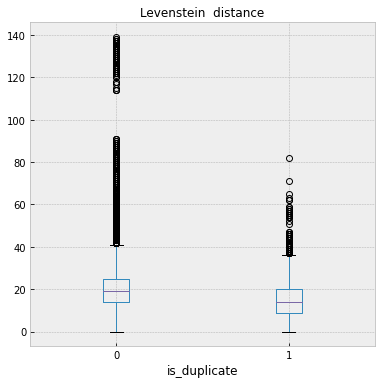

In [26]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

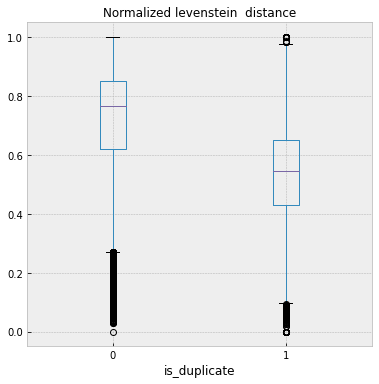

In [27]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

# Методы машинного обучения

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [48]:
def bow(train, test):
    bow_vectorizer = CountVectorizer()
    train_vec = bow_vectorizer.fit_transform(train)
    test_vec = bow_vectorizer.transform(test)
    return train_vec, test_vec

In [49]:
def tf_idf(train, test):
    tfidf_vectorizer = TfidfVectorizer()
    train_vec = tfidf_vectorizer.fit_transform(train)
    test_vec = tfidf_vectorizer.transform(test)
    return train_vec, test_vec

In [50]:
def knn_score(trainX, trainY, testX, testY):
    knn_classifier = KNeighborsClassifier()
    knn_classifier.fit(trainX, trainY)
    return knn_classifier.score(testX, testY)

In [53]:
def random_forest_score(trainX, trainY, testX, testY):
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(trainX, trainY)
    return rf_classifier.score(testX, testY)

In [52]:
def lr_score(trainX, trainY, testX, testY):
    lr_classifier = LogisticRegression()
    lr_classifier.fit(trainX, trainY)
    return lr_classifier.score(testX, testY)

In [54]:
def visualize_results(score):
    print(score)

def base_pipeline(train_x, train_y, test_x, test_y,
                  vectorizer, scorer):
    vectorized_train_x, vectorized_test_x = vectorizer(train_x, test_x)
    score = scorer(vectorized_train_x, train_y, vectorized_test_x, test_y)
    visualize_results(score)

# Базовая модель

In [56]:
FTS = ["levenstein", "norm_levenstein"]
THR = 0.9

In [ ]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=RS)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [ ]:
model = LogisticRegression(class_weight="balanced")
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

In [ ]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [ ]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [ ]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

In [ ]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

In [ ]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

# Генерация сабмита

In [ ]:
sample_sub = pd.read_csv(DATA_DIR.joinpath("sample_submission.csv"), index_col="pair_id")

In [ ]:
sample_sub

In [ ]:
sample_sub["is_duplicate"] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)

In [ ]:
sample_sub.is_duplicate.value_counts()

In [ ]:
sample_sub.to_csv(DATA_DIR.joinpath("baseline_submission.csv"))